# Project definition

Sparkify is a fictitious company which requires a Machine Learning project aimed at predicting user churn for their music streaming service. Utilizing a broad array of user-generated event data, the project leverages Apache Spark for processing and analyzing large volumes of data to enable feature engineering and predictive model development. User characteristics such as platform activity, songs listened to, interface interactions, and demographic information are provided to predict the likelihood of users discontinuing the service. This approach allows for the implementation of proactive strategies to enhance user retention and optimize user experience on the platform.

# Analysis

## Data Exploration

On the following cell we'll start by loading the necessary libraries and doing a quick check that consists of seeing the schema that spark interpreted and seeing a sample of 20 rows

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import from_json, col, explode, split, base64, sum, count, when, isnan, max
from pyspark.sql.types import StructType, StructField, DecimalType, StringType, LongType

spark = SparkSession.builder.appName("Sparkify-Clean").getOrCreate()

df = spark.read.json("mini_sparkify_event_data.json")

df.printSchema()
print(df.count())
df.show()

24/04/10 13:23:56 WARN Utils: Your hostname, miguel-ubuntu-22 resolves to a loopback address: 127.0.1.1; using 192.168.83.131 instead (on interface ens33)
24/04/10 13:23:56 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/10 13:23:57 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



286500
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|           page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|      Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|       NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|    Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| fr

Now, let's look at the amount of missing data on each column.

In [2]:
total_rows = df.count()

nulls_percentages = df.select([
    (count(when(col(c).isNull() | isnan(c), c)) / total_rows * 100).alias(c)
    for c in df.columns
])

nulls_percentages.show()

+------------------+----+-----------------+-----------------+-------------+-----------------+------------------+-----+-----------------+------+----+-----------------+---------+------------------+------+---+-----------------+------+
|            artist|auth|        firstName|           gender|itemInSession|         lastName|            length|level|         location|method|page|     registration|sessionId|              song|status| ts|        userAgent|userId|
+------------------+----+-----------------+-----------------+-------------+-----------------+------------------+-----+-----------------+------+----+-----------------+---------+------------------+------+---+-----------------+------+
|20.381151832460734| 0.0|2.913089005235602|2.913089005235602|          0.0|2.913089005235602|20.381151832460734|  0.0|2.913089005235602|   0.0| 0.0|2.913089005235602|      0.0|20.381151832460734|   0.0|0.0|2.913089005235602|   0.0|
+------------------+----+-----------------+-----------------+-----------

As it can be seen on the cell above:
- 2.91% of users are missing, which doesn't make sense, in this case we'll remove those rows as actions should be performed by users, this amount could be by direct queries to an API or a backend of some sort so we won't keep those rows.
- About 20% of records don't have a song or artist related to them , which makes sense as not all of the actions on Sparify are related to music streaming.

From the information above we can start seeing some important aspects of the data.
- userId: This is most likely a primary key representing the user, it has been incorrectly labeled as string, so we should do something about it.
- page: We should be able this to label if a customer has churned or not using this column, we'll have a look in more detail at this feature down below.
- status: This can give us an idea of whether or not a customer has experienced issues with sparkify's website/app.

On the next cell we'll pre-process the data by applying a schema and removing rows with no users related to them.

The process will be:
1. Define the schema using StructType.
2. Read the dataframe (again) and apply the new schema to the dataframe.

In [3]:
schema = StructType([
    StructField("userId", DecimalType(16, 0), nullable=False),
    StructField("firstName", StringType(), nullable=True),
    StructField("lastName", StringType(), nullable=True),
    StructField("gender", StringType(), nullable=True),
    StructField("level", StringType(), nullable=True),
    StructField("location", StringType(), nullable=True),
    StructField("registration", LongType(), nullable=True),
    StructField("page", StringType(), nullable=True),
    StructField("method", StringType(), nullable=True),
    StructField("status", LongType(), nullable=True),
    StructField("sessionId", LongType(), nullable=True),
    StructField("auth", StringType(), nullable=True),
    StructField("itemInSession", LongType(), nullable=True),
    StructField("artist", StringType(), nullable=True),
    StructField("song", StringType(), nullable=True),
    StructField("length", DecimalType(16, 5), nullable=True),
    StructField("ts", LongType(), nullable=True),
    StructField("userAgent", StringType(), nullable=True)
])

events = spark.read.schema(schema).option("mode", "PERMISSIVE").json("mini_sparkify_event_data.json").where("userId IS NOT NULL")
# This is the full dataset, we'll use it for testing
full_events = spark.read.schema(schema).option("mode", "PERMISSIVE").json("mini_sparkify_event_data_full.json").where("userId IS NOT NULL")
events.printSchema()

# Events has less data, as the original dataset, which is expected.
print(events.count(), df.count())

root
 |-- userId: decimal(16,0) (nullable = true)
 |-- firstName: string (nullable = true)
 |-- lastName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- page: string (nullable = true)
 |-- method: string (nullable = true)
 |-- status: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- auth: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- artist: string (nullable = true)
 |-- song: string (nullable = true)
 |-- length: decimal(16,5) (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)



278154 286500


Since this is a classification problem for users, I'd like to see how many users are available on this dataset, we only have a total of 225 users which is a small number in my opinion.

In [4]:
events.select("userId").distinct().count()

225

Now we'll have a look at the distribution of data for the following columns:
- gender
- level
- page
- artist and song (just out of curiosity)
- ts

In [5]:
# Function that we'll use to plot the distribution of values.
import matplotlib.pyplot as plt

def plot_top_n_values(df, column_name, n, orient='vertical'):
    """
    Plots the top N most frequent values (including nulls) for a specified column in a Spark DataFrame.

    Parameters:
    - df (pyspark.sql.DataFrame): The Spark DataFrame containing the data to be plotted.
    - column_name (str): The name of the column in `df` for which the top N values will be plotted.
    - n (int): The number of top values to plot.
    - orient (str, optional): The orientation of the plot. Can be 'vertical' or 'horizontal'. Default is 'vertical'.

    Returns:
    - None. Displays a matplotlib plot.

    Example usage:
    ```
    plot_top_n_values(df=my_spark_dataframe, column_name='my_column', n=10, orient='horizontal')
    ```
    """
    # This is to make sure we also count nulls (when applicable)
    count_df = df.select(column_name, when(col(column_name).isNull(), 'Null').otherwise(col(column_name)).alias('value')) \
                 .groupBy('value') \
                 .count() \
                 .orderBy('count', ascending=False) \
                 .limit(n)
    
    top_n_values = count_df.collect()
    
    values = [row['value'] for row in top_n_values]
    counts = [row['count'] for row in top_n_values]
    
    plt.figure(figsize=(10, 8))
    
    if orient == 'horizontal':
        plt.barh(values, counts, color='skyblue')
        plt.xlabel('Frequency')
        plt.ylabel('Values')
        plt.title(f'Top {n} values in column {column_name}')
    else:
        plt.bar(values, counts, color='skyblue')
        plt.xlabel('Values')
        plt.ylabel('Frequency')
        plt.title(f'Top {n} values in column {column_name}')
        plt.xticks(rotation=45)
    
    plt.show()


Gender, we can see most of our users are Males.

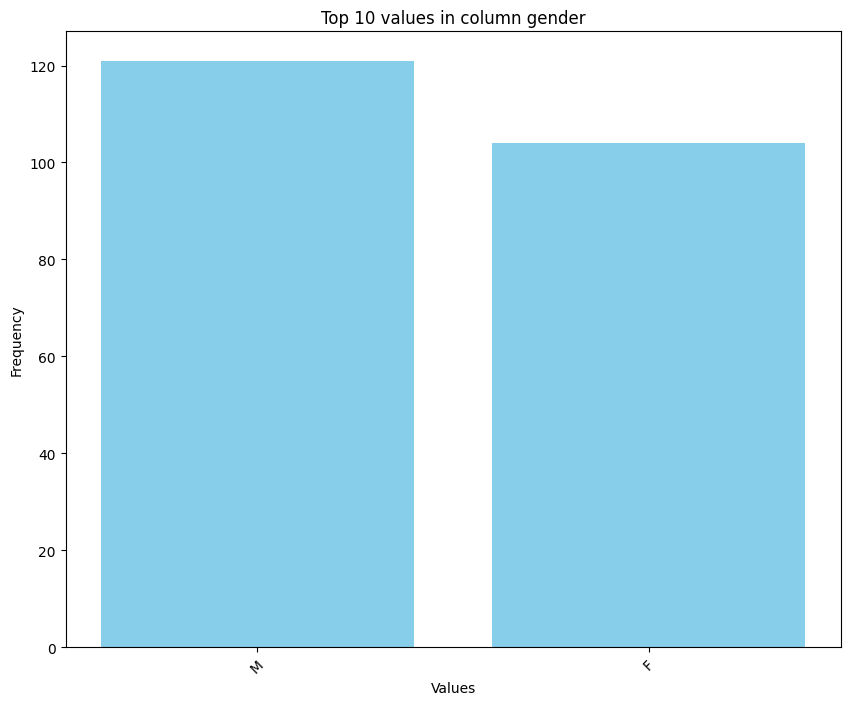

In [6]:
plot_top_n_values(events.select("userId","gender").distinct(), 'gender', 10)

However, women seem to interact more with the application.

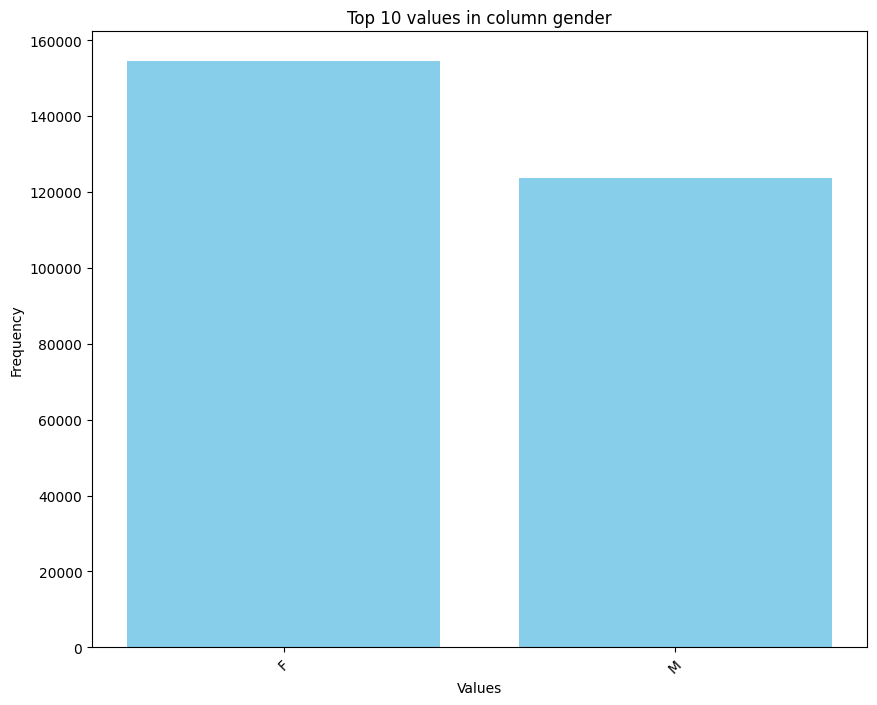

In [7]:
plot_top_n_values(events.select("gender"), 'gender', 10)

Level, most of our users are free users.

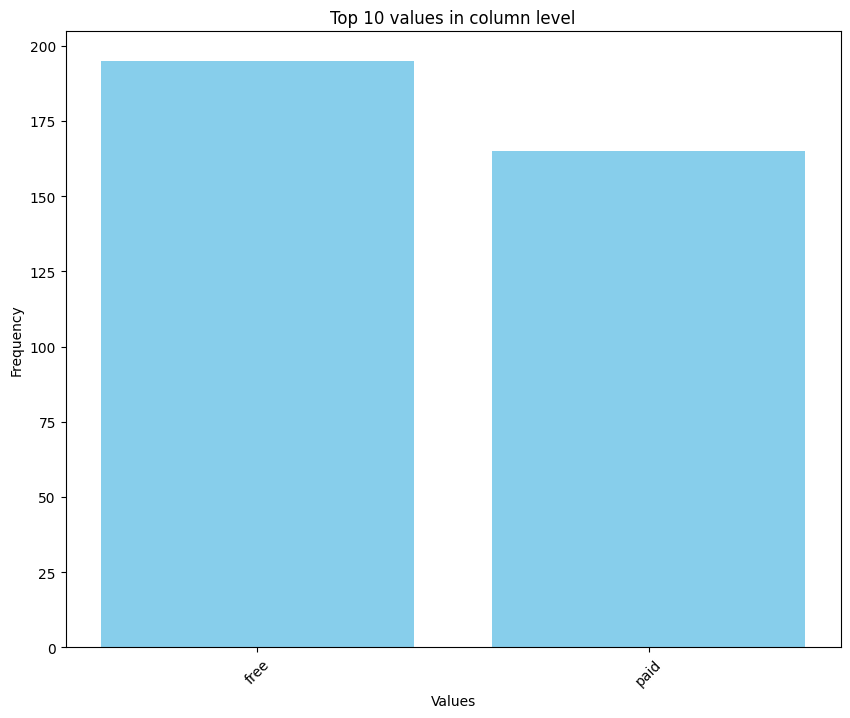

In [8]:
plot_top_n_values(events.select("userId","level").distinct(), 'level', 10)

Page, by far the most visited page is next song, so much so that we can hardly see the rest of the data. 

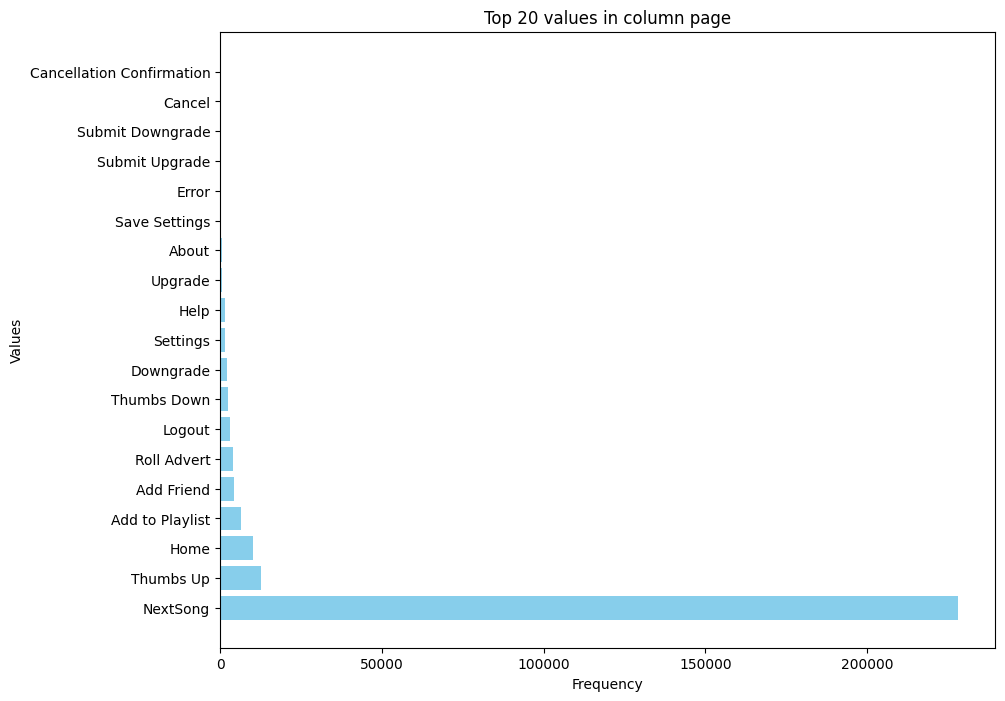

In [9]:
plot_top_n_values(events, 'page', 20, orient='horizontal')

We can exclude "NextSong" from the plot to better see the rest of the values.
There's a really small value of cancellations and downgrades compared to the rest of values.

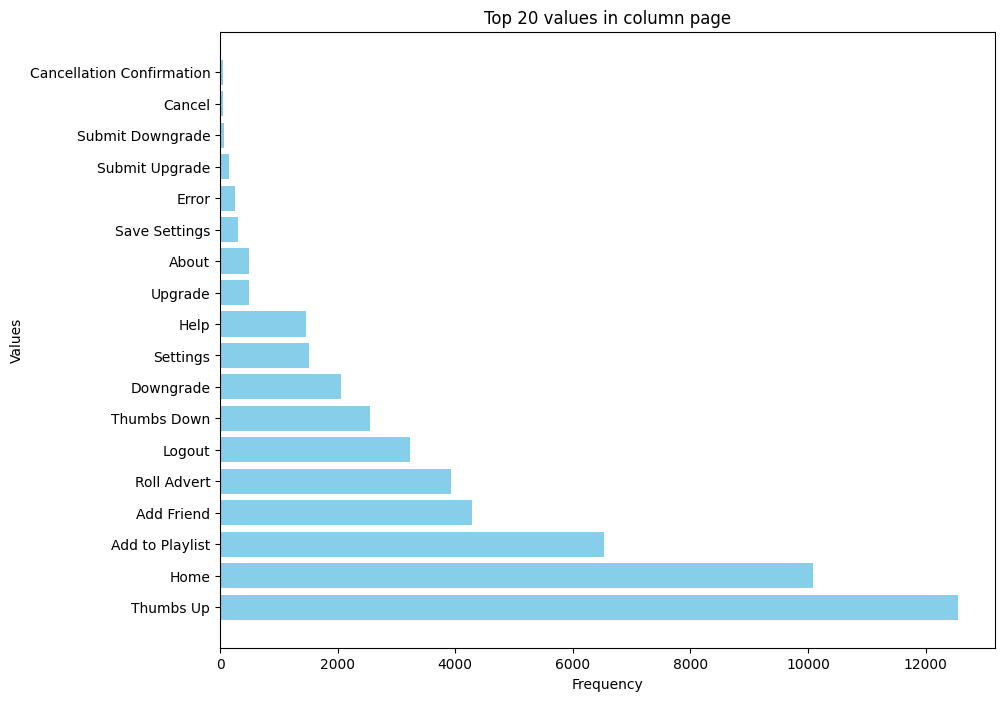

In [10]:
plot_top_n_values(events.where("page != 'NextSong'"), 'page', 20, orient='horizontal')

Just out of curiosity we can see which are the more popular artists and songs.

/home/miguel/Documents/udacity-ds-nanodegree-pj-4/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 131 (\x83) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


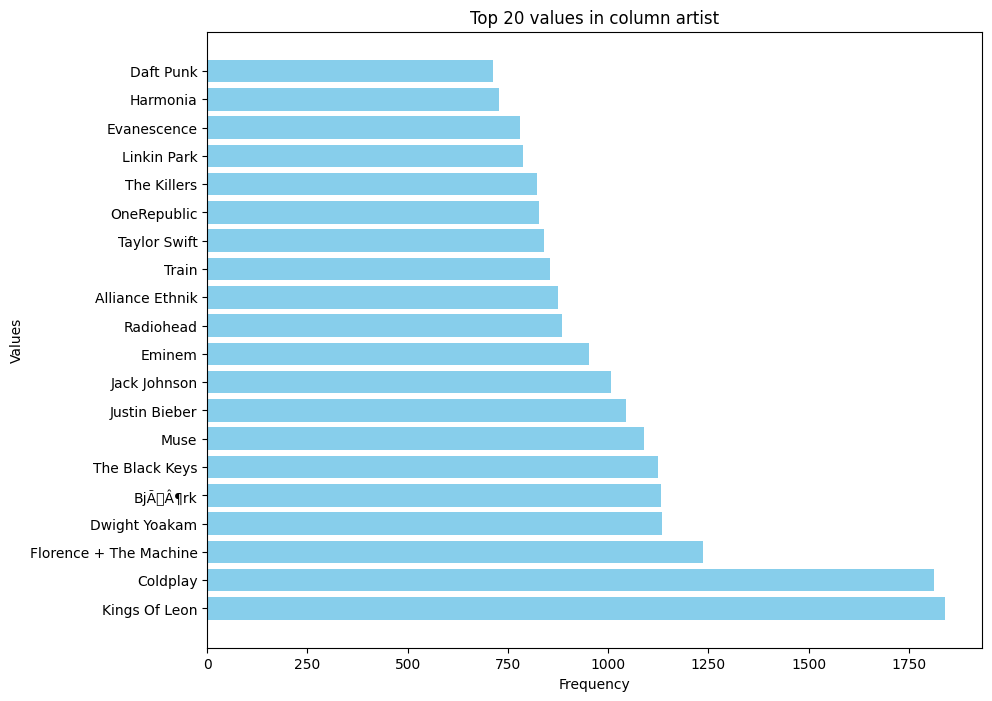

In [11]:
plot_top_n_values(events.where("artist is not null"), 'artist', 20, orient='horizontal')

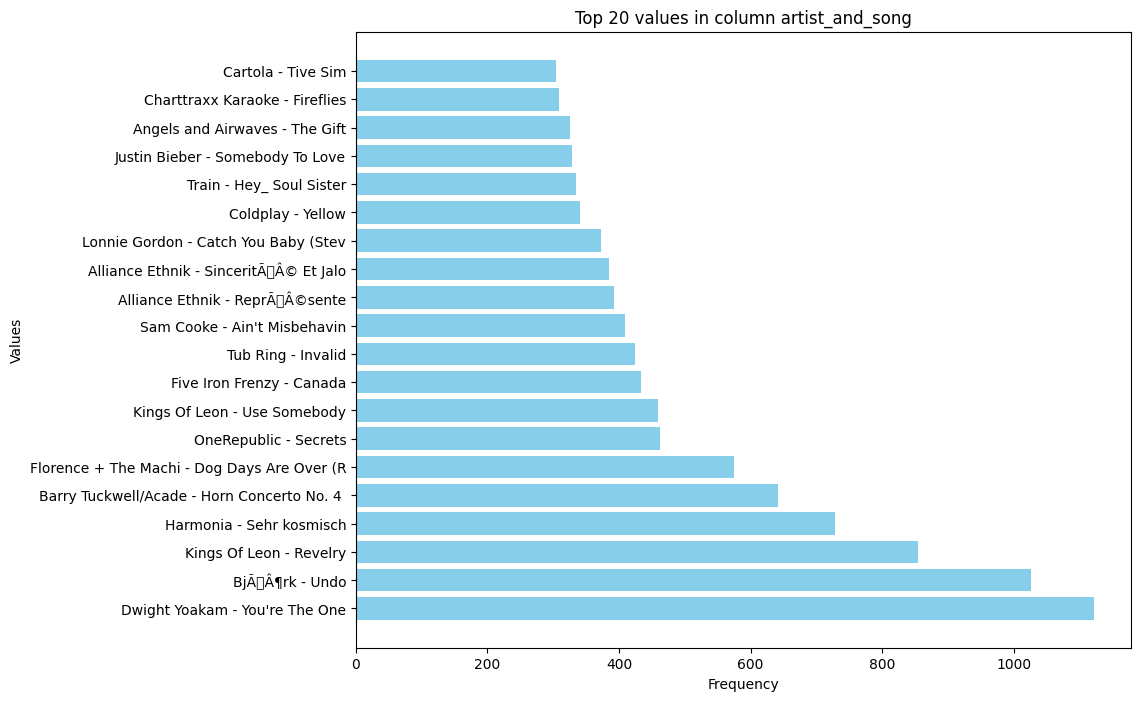

In [12]:
plot_top_n_values(events.where("song is not null").selectExpr("CONCAT(substr(artist,1,20),' - ',substr(song,1,20)) as artist_and_song"), 'artist_and_song', 20, orient='horizontal')

Now that we have a better understanding of data we can start to think about one of the main that we'll encounter with this dataset:
How can we define churn?

In [13]:
df.select("page").distinct().show(n=50,truncate=False)

+-------------------------+
|page                     |
+-------------------------+
|Cancel                   |
|Submit Downgrade         |
|Thumbs Down              |
|Home                     |
|Downgrade                |
|Roll Advert              |
|Logout                   |
|Save Settings            |
|Cancellation Confirmation|
|About                    |
|Settings                 |
|Login                    |
|Add to Playlist          |
|Add Friend               |
|NextSong                 |
|Thumbs Up                |
|Help                     |
|Upgrade                  |
|Error                    |
|Submit Upgrade           |
|Submit Registration      |
|Register                 |
+-------------------------+



As suggested on the initial notebook, we'll use the cancellation confirmation event to define "churn":

"create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users."

Let's start by seeing how many users have churned, in total 50 users in our dataset have churned.

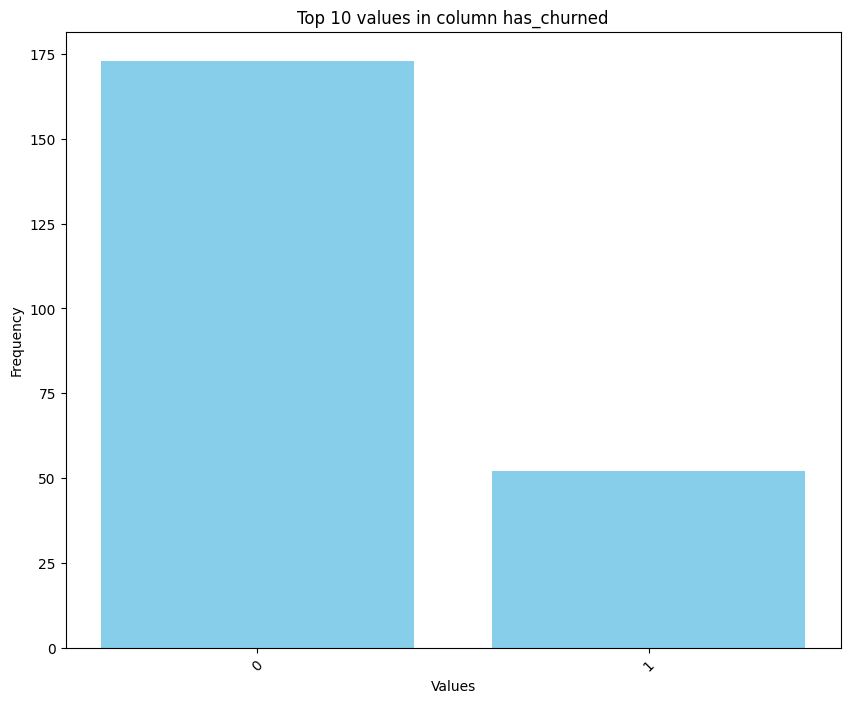

In [14]:
churned_users = events.selectExpr("userId", "case when page = 'Cancellation Confirmation' then 1 else 0 end as is_churn_page")\
    .groupBy("userId")\
    .agg(max("is_churn_page").alias("has_churned"))

plot_top_n_values(churned_users, 'has_churned', 10)

As a sanity check, let's see if this approach makes sense, to do this I'll check if the LAST action performed by an user is on the "Cancellation Confirmation" page.

Why is this important?

If a user still interacts with the page AFTER the cancellation, then this is not the correct way to define "churn" on the other hand, if the last action performed by an user is to cancel and we don't see more interactions, it means our approach to define churn is correct.

As seen below, this approach to define churn makes sense.

In [15]:
from pyspark.sql.window import Window
from pyspark.sql.functions  import lead

# Defining a partition window by user ID and ordered by ts , this way we have the events in chronological order
windowSpec = Window.partitionBy("userId").orderBy("ts")
# We check if there's ANY action after the current action
events_with_lead = events.withColumn("next_action", lead("page", 1).over(windowSpec))
# We filter all the events of type Cancellation Confirmation and we check if there's an action AFTER the current event
events_post_cancellation = events_with_lead.filter((events_with_lead.page == "Cancellation Confirmation") & (events_with_lead.next_action.isNotNull()))
# 0 records, this approach makes sense
events_post_cancellation.select("userId", "page", "ts", "next_action").show()


+------+----+---+-----------+
|userId|page| ts|next_action|
+------+----+---+-----------+
+------+----+---+-----------+



## Feature engineering

Now we can start with the machine learning tasks, here's what we'll do:
1. We'll summarize (count) all of the actions that a user did on the app (excluding the cancellation event), we can think of this like a "bag of words" for NLP problems, but in this case it'll be a "bag of events" for all users.
2. We'll pre-process the data, doing the following:
- We'll convert timestamp to dates
- We'll calculate active time on platform, how much time has a user existed on our platform since it's registration date until the last recorded event.
- Songs on session, we'll calculate how many songs (on average) users listen to on a given session.

Now, for the datasets this will be the approach:
- We'll do training on the small dataset.
- Once training is finished we'll do testing on the complete dataset, so we can see how the model would perform on a real world scenario.

In [16]:
from pyspark.sql.functions import from_unixtime, col, datediff, when, count, max, avg

def convert_df_to_bag_of_events(df):
    """
    Convert a Spark DataFrame of user events into a 'bag of events' format for analysis, 
    focusing on user activity and churn status.

    Parameters:
    - df (pyspark.sql.DataFrame): The input Spark DataFrame containing user events, with columns 
                                  for timestamps ('ts'), registration time ('registration'), 
                                  page actions ('page'), and user IDs ('userId').

    Returns:
    - pyspark.sql.DataFrame: The transformed DataFrame in a 'bag of events' format, with aggregated 
                             user metrics and event counts, suitable for analysis of user behavior 
                             and churn.

    Example usage:
    ```
    processed_events = convert_df_to_bag_of_events(events)
    processed_full_events = convert_df_to_bag_of_events(full_events)
    ```
    """
    # Processing date column and calculating active time on platform
    df = df.withColumn("action_date", from_unixtime(col("ts") / 1000))
    df = df.withColumn("registration_date", from_unixtime(col("registration") / 1000))
    df = df.withColumn("active_time_on_platform", datediff(col("action_date"),col("registration_date")))

    # Adding a has_churned column
    df = df.withColumn("has_churned", when(col("page").isin("Cancellation", "Cancellation Confirmation"), 1).otherwise(0))

    # Aggregating metrics by user ID, to correctly flag the user as churned and to correctly calculate the active time on platform
    user_summary = df.groupBy("userId") \
        .agg(max("active_time_on_platform").alias("active_time"), \
            count("*").alias("total_records"), \
            max("has_churned").alias("churned"))

    # Creating bag of events
    page_counts = df.groupBy("userId") \
        .pivot("page") \
        .count()

    final_df = user_summary.join(page_counts, "userId", "inner")

    #Here we remove all columns that could cause overfitting
    final_df = final_df.drop("Cancel","Cancellation Confirmation","userId", "Submit Downgrade")
    final_df = final_df.fillna(0)

    return final_df

processed_events = convert_df_to_bag_of_events(events)
processed_full_events = convert_df_to_bag_of_events(full_events)

## Modeling

With the newly created dataset we can set up our ML pipeline and check which model has a better performance.

From the cell below it seems that the two models that present the best performance are Logistic Regression and Random Forest.

Be aware: If you try to run the cells it can take quite sometime to finish.

First let's define a function to train the models

In [17]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

def calculate_model_metrics(trained_model, dataset, label_col):
    """
    Evaluates a trained model on a given dataset using various metrics including ROC AUC, accuracy, F1 score,
    precision, and recall.

    Parameters:
    - trained_model (PipelineModel): The trained Spark ML model (pipeline) to evaluate.
    - dataset (DataFrame): The Spark DataFrame containing the test data.
    - label_col (str): The name of the column in `dataset` that contains the true label.

    Returns:
    tuple: A tuple containing the calculated metrics in the following order: ROC AUC, accuracy, F1 score,
           precision, and recall.

    Example usage:
    ```
    roc, accuracy, f1_score, precision, recall = calculate_model_metrics(trained_model, test_dataset, 'label')
    ```
    """
    predictions = trained_model.transform(dataset)

    roc_auc_evaluator = BinaryClassificationEvaluator(labelCol=label_col)
    roc = roc_auc_evaluator.evaluate(predictions)

    classification_evaluator = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol="prediction", metricName="accuracy")

    accuracy_evaluator = classification_evaluator
    accuracy = accuracy_evaluator.evaluate(predictions)

    classification_evaluator.setMetricName("f1")
    f1_evaluator = classification_evaluator
    f1_score = f1_evaluator.evaluate(predictions)

    classification_evaluator.setMetricName("weightedPrecision")
    precision_evaluator = classification_evaluator
    precision = precision_evaluator.evaluate(predictions)

    classification_evaluator.setMetricName("weightedRecall")
    recall_evaluator = classification_evaluator
    recall = recall_evaluator.evaluate(predictions)

    return roc, accuracy, f1_score, precision, recall

def train_classifiers(classifiers, assembler, train_set, test_set):
    """
    Trains multiple classifiers on a training dataset, evaluates them on a test dataset using cross-validation,
    and returns the performance metrics.

    Parameters:
    - classifiers (list of dicts): A list where each dict contains the classifier, its name, and the parameter
      grid for cross-validation.
    - assembler (VectorAssembler): The VectorAssembler object used to combine feature columns into a single vector.
    - train_set (DataFrame): The Spark DataFrame containing the training data.
    - test_set (DataFrame): The Spark DataFrame containing the test data.

    Returns:
    list: A list of dictionaries, where each dictionary contains the name of the classifier and its performance
          metrics on the training and test sets.

    Example usage:
    ```
    classifiers = [{"classifier": LogisticRegression(), "name": "LR", "params": paramGrid}]
    ```
    """
    models_data = []
    for classifier_obj in classifiers:
        classifier = classifier_obj["classifier"]
        classifier_name = classifier_obj["name"]
        estimator_params = classifier_obj["params"]
        print(f"Evaluating : {classifier_name}")

        label_col = "churned"

        pipeline = Pipeline(stages=[assembler, classifier])
        crossval = CrossValidator(estimator=pipeline,
                                estimatorParamMaps=estimator_params,
                                evaluator=BinaryClassificationEvaluator(labelCol=label_col),
                                numFolds=5)

        cvModel = crossval.fit(train_set)
        bestModel = cvModel.bestModel

        train_roc, train_accuracy, train_f1_score, train_precision, train_recall = calculate_model_metrics(bestModel, train_set, label_col)
        test_roc, test_accuracy, test_f1_score, test_precision, test_recall = calculate_model_metrics(bestModel, test_set, label_col)

        models_data.append(
            [
                bestModel, 
                {
                    "name": classifier_name
                    , "train_roc" : train_roc
                    , "train_accuracy" : train_accuracy
                    , "train_f1_score" : train_f1_score
                    , "train_precision" : train_precision
                    , "train_recall" : train_recall
                    , "test_roc" : test_roc
                    , "test_accuracy" : test_accuracy
                    , "test_f1_score" : test_f1_score
                    , "test_precision" : test_precision
                    , "test_recall": test_recall
                }
            ]
        )
    return models_data



Now let's use the method created below.
For each of the classifiers below we'll start by using the default parameters , the idea being to get a baseline of performance for each of the possible options and fine-tune the models afterwards.
Beware if you execute the cells below they might take sometime to complete.

In [32]:
from pyspark.ml.classification import RandomForestClassifier, DecisionTreeClassifier, GBTClassifier, LinearSVC, LogisticRegression, MultilayerPerceptronClassifier

feature_cols = processed_events.columns
feature_cols.remove('churned')

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

numFeatures = len(feature_cols)

classifiers = [
    {"name": "Random Forest","classifier": RandomForestClassifier(labelCol="churned", featuresCol="features"), "params": [{}]},
    {"name": "Decision Tree","classifier": DecisionTreeClassifier(labelCol="churned", featuresCol="features"), "params": [{}]},
    {"name": "Gradient-boosted","classifier": GBTClassifier(labelCol="churned", featuresCol="features", maxIter=10), "params": [{}]},
    {"name": "Linear SVM", "classifier": LinearSVC(labelCol="churned", featuresCol="features"), "params": [{}]},
    {"name": "Logistic Regression", "classifier": LogisticRegression(labelCol="churned", featuresCol="features"), "params": [{}]},
    {"name": "Multilayer perceptron", "classifier": MultilayerPerceptronClassifier(layers=[numFeatures, 5, 4, 2], labelCol="churned", featuresCol="features", maxIter=100), "params": [{}]}
]

initial_metrics = train_classifiers(classifiers, assembler, processed_events, processed_full_events)

Evaluating : Random Forest


Evaluating : Decision Tree


Evaluating : Gradient-boosted


Evaluating : Linear SVM


24/04/10 16:40:11 WARN BlockManager: Asked to remove block broadcast_66053, which does not exist


Evaluating : Logistic Regression


Evaluating : Multilayer perceptron


24/04/10 17:03:56 ERROR LBFGS: Failure! Resetting history: breeze.optimize.FirstOrderException: Line search zoom failed


In the cell below you'll be able to see the results.
Some important observations are:
- On the training set gradient-boost seems to explain all of the variance of the dataset, however on the testing set that's not the case, the model only explains about 67% of the variance of the dataset and the accuracy seems pretty low (74%) when compared to the train accuracy, this seems a case of overfitting.
- Multilayer perceptron and Decision trees seems to have a poor performance when compared to other methods.
- Linear SVM and Random Forest seem to have pretty solid numbers for all classification metrics.
- Overall, the best perfomant model seems to be logistic regression, it has the best metrics overall.

Now that we've seen the metrics, we'll focus on two models, logistic regression and random forest.

In [33]:
import pandas as pd

initial_metrics_array = [ x[1] for x in initial_metrics ]

initial_metrics_df = pd.DataFrame.from_dict(initial_metrics_array)
initial_metrics_df

,name,train_roc,train_accuracy,train_f1_score,train_precision,train_recall,test_roc,test_accuracy,test_f1_score,test_precision,test_recall
0,Random Forest,0.971988,0.906667,0.898665,0.912904,0.906667,0.731665,0.815199,0.786670,0.799064,0.815199
1,Decision Tree,0.734549,0.937778,0.935888,0.937514,0.937778,0.498714,0.737454,0.729029,0.722509,0.737454
2,Gradient-boosted,1.000000,0.986667,0.986526,0.986894,0.986667,0.674038,0.747643,0.743610,0.740127,0.747643
3,Linear SVM,0.821476,0.831111,0.808865,0.823026,0.831111,0.697792,0.804561,0.774859,0.782501,0.804561
4,Logistic Regression,0.923522,0.875556,0.874693,0.874006,0.875556,0.820023,0.857842,0.853022,0.851479,0.857842
5,Multilayer perceptron,0.710983,0.782222,0.763551,0.758792,0.782222,0.696402,0.752850,0.725762,0.714535,0.752850


On the next part we'll focus on random forest and logistic regression.

In [20]:
from pyspark.ml.tuning import ParamGridBuilder

classifiers = [
    {"name": "Random Forest",
     "classifier": RandomForestClassifier(labelCol="churned", featuresCol="features"),
     "params": ParamGridBuilder()
                .addGrid(RandomForestClassifier.numTrees, [10, 20, 30])
                .addGrid(RandomForestClassifier.maxDepth, [5, 10, 20])
                .addGrid(RandomForestClassifier.maxBins, [32, 64])
                .addGrid(RandomForestClassifier.minInstancesPerNode, [1, 2])
                .build()},
    {"name": "Logistic Regression",
     "classifier": LogisticRegression(labelCol="churned", featuresCol="features"),
     "params": ParamGridBuilder()
                .addGrid(LogisticRegression.maxIter, [10, 100, 200])
                .addGrid(LogisticRegression.regParam, [0.01, 0.1, 0.5])
                .addGrid(LogisticRegression.elasticNetParam, [0.0, 0.5, 1.0])
                .build()}
]

metrics = train_classifiers(classifiers, assembler, processed_events, processed_full_events)

Evaluating : Random Forest


Evaluating : Logistic Regression


24/04/10 14:54:51 WARN BlockManager: Asked to remove block broadcast_22997, which does not exist
24/04/10 15:09:18 WARN BlockManager: Asked to remove block broadcast_30966, which does not exist


After the parameter tunning (which took longer to complete than the previous cell) we can see that the results were not significantly improved, actually seems like the "best model" are still the ones with default parameters.


In [34]:
metrics_array = [ x[1] for x in metrics ]

metrics_df = pd.DataFrame.from_dict(metrics_array)
metrics_df

,name,train_roc,train_accuracy,train_f1_score,train_precision,train_recall,test_roc,test_accuracy,test_f1_score,test_precision,test_recall
0,Random Forest,0.971988,0.906667,0.898665,0.912904,0.906667,0.731671,0.815199,0.786670,0.799064,0.815199
1,Logistic Regression,0.923522,0.875556,0.874693,0.874006,0.875556,0.820027,0.857842,0.853022,0.851479,0.857842


It seems that Logistic Regression is going to win the competition this time as it has better metrics across the board, now that we know this let's have a look at which are the most important features to build the model.

In [39]:
lr_model = metrics[1][0].stages[-1]

coefficients = lr_model.coefficients

for idx in range(0, len(coefficients)):
    print(feature_cols[idx] , " = ", coefficients[idx])

active_time  =  -0.028285774674928828
total_records  =  1.4397493034841988
About  =  -2.1341857658651326
Add Friend  =  -1.455248393186084
Add to Playlist  =  -1.2923459342633068
Downgrade  =  -1.123535474164477
Error  =  -1.8117768919828423
Help  =  -1.3234611634314646
Home  =  -1.6510321994854391
Logout  =  -1.0263307296701278
NextSong  =  -1.4488634517769612
Roll Advert  =  -1.4047235764965413
Save Settings  =  -0.9992259323195376
Settings  =  -1.2516691441499104
Submit Upgrade  =  -1.8665947777823044
Thumbs Down  =  -1.5525470208255756
Thumbs Up  =  -1.3747012581212243
Upgrade  =  -1.0922464983754632


This is interesting! there are no clear winners into which factors influence user retention.
However, the frequency of visits to pages "about", "submit upgrade" and "error" seem to have the strongest negative association, suggesting a potential correlation with user unsuscribing from the service.

## Conclusion

### Results

- After all the modeling is finished, we have a pretty solid model to predict whether or not the user will churn with an accuracy, precision and recall of about 85%.

### Solution

The entire solution can be broken down on the following steps:
- Define a schema to clean the data
- We remove rows without users (there are no easy imputation methods for this scenario)
- Every action that a user performs is transformed to a "bag of events", basically a count for each action that the user did
- A model was trained on the data in this new format (after testing several models on ML Pipelines), this model can now be used to predict user retention based on their actions on our app

There were some challenging aspects of this project:
- It was a challenge to understand how to define churn and how to properly process the user actions to be able to feed the data into a machine learning algorithm.
- Moreover I created several visualizations (that were not included as they didn't add any value for the project) to try to figure out which ML models would work better (mainly scatterplots and histograms), but they weren't useful and didn't provide any insight on which models would work better or if there were any important patterns on the data.

### Improvements

Regarding the model as it can be seen there's definitely a drop in performance between training and test set, this could be due to the fact that we have an imbalanced dataset, ideally we should include more data from the test set so that the model is able to better understand the underlaying patterns. If that is not possible we could create some synthetic data with techniques such as SMOTE, however I also think that for this exercise the model's performance is good enough.